# Part 2

So, now that I've looked at my artists month to month. I want to look at the features of my songs to see if there are some insights into why I listen to music the way I do.

To query data from the Spotify API, I'm going to use a library called Spotipy that does a lot of the server side work for us and wraps them in neat function calls.

In [1]:
import secret
import spotipy

from spotipy.oauth2 import SpotifyClientCredentials
cid = secret.client_id
secret = secret.client_secret
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Gotta import the data again

In [2]:
import pandas as pd

df_data = pd.read_json("one_year_streaming_history0.json")
df_data['endTime'] = pd.to_datetime(df_data['endTime']) 
df_data.head()

,endTime,artistName,trackName,msPlayed
0,2019-01-05 05:32:00,Tonight Alive,World Away,0
1,2019-01-05 05:36:00,Eminem,Greatest,226937
2,2019-01-05 05:40:00,Elephante,Sirens,249411
3,2019-01-05 05:45:00,Mike Williams,Bambini,2972
4,2019-01-05 05:45:00,Panic! At The Disco,High Hopes,190946


df_data.shape

There's quite a lot of songs in this data, but many are duplicates. Thus I'll group them together and sum the amount of time I listened to those songs.

In [3]:
df_by_song = df_data.groupby([df_data['trackName'], df_data['artistName']]).sum().reset_index()
df_by_song

,trackName,artistName,msPlayed
0,!!!!!!!,Billie Eilish,13578
1,&burn (with Vince Staples),Billie Eilish,358030
2,*Sobs Quietly*,Mom Jeans.,118464
3,10 Feet Down,NF,16958
4,"10,000 Hours (with Justin Bieber)",Dan + Shay,2012316
...,...,...,...
1276,whywhywhy,MisterWives,401360
1277,wish you were gay,Billie Eilish,225769
1278,xanny,Billie Eilish,243725
1279,you should see me in a crown,Billie Eilish,3444478


There's over 1200 songs in that list, but I'm only interested in the songs that I actually liked. To select these, I'm only going to select songs that I listened to more than 5 times.

This is calculated by assuming the average songs length is ~3 minutes (180000ms) and multiplying that by 5.

I'm doing this before querying from the API to keep my usage down.

In [14]:
songs_liked = df_by_song.loc[df_by_song['msPlayed'] > (180000 * 5)].sort_values(by='msPlayed', ascending=False).reset_index(drop=True)
songs_liked

,trackName,artistName,msPlayed
0,America Online,The Midnight,13237685
1,Until the End of Time,For The Win,12448580
2,The Search,NF,11221608
3,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297
4,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797
...,...,...,...
186,Gold,Kiiara,1132086
187,Rebel Girl,Angels & Airwaves,1130035
188,I'm Not Racist,Joyner Lucas,1127251
189,Goodbyes (feat. Young Thug),Post Malone,1049118


Brings us down to a healthy 191 songs.

Next, I'm going to query from Spotify's API. Here I'm only getting the uri (so that I can get more advanced data later), the popularity of the song, and the length of the song which I will use to calculate the number of times I played that song.

In [15]:
import numpy as np
songs_liked['uri'] = ""
songs_liked['popularity'] = np.nan
songs_liked['songLengthMs'] = np.nan
songs_liked['timesPlayed'] = np.nan


for idx, row in songs_liked.iterrows():
    results = sp.search(q='artist:{} track:{}'.format(
        songs_liked['artistName'][idx].lower(),
        songs_liked['trackName'][idx][:8].lower(), type='track'))

    try:
        uri = results['tracks']['items'][0]['uri'].split(':')[2]
        popularity = results['tracks']['items'][0]['popularity']
        song_length = results['tracks']['items'][0]['duration_ms']
        times_played = round(songs_liked['msPlayed'][idx] / song_length, 2)
    except:
        IndexError

    songs_liked.at[idx, 'uri'] = uri
    songs_liked.at[idx, 'popularity'] = popularity
    songs_liked.at[idx, 'songLengthMs'] = song_length
    songs_liked.at[idx, 'timesPlayed'] = times_played

songs_liked

,trackName,artistName,msPlayed,uri,popularity,songLengthMs,timesPlayed
0,America Online,The Midnight,13237685,5eSYigDAtbgTm5iQLTeMJP,52.0,349705.0,37.85
1,Until the End of Time,For The Win,12448580,4XcmsnRjjCECEqJvsbH0ot,36.0,272730.0,45.64
2,The Search,NF,11221608,2OKo7g3KfmCt3kyLvUAL0g,73.0,248040.0,45.24
3,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297,3g0mEQx3NTanacLseoP0Gw,85.0,209880.0,52.99
4,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797,6EbduYTr62sSzvl36wWiFM,69.0,209120.0,52.89
...,...,...,...,...,...,...,...
186,Gold,Kiiara,1132086,6ZSO7kPn8IMJFymyticbJO,68.0,225882.0,5.01
187,Rebel Girl,Angels & Airwaves,1130035,1EEt3kxO1yZSZd13DqvT8f,53.0,226007.0,5.00
188,I'm Not Racist,Joyner Lucas,1127251,1EEt3kxO1yZSZd13DqvT8f,53.0,226007.0,5.00
189,Goodbyes (feat. Young Thug),Post Malone,1049118,0t3ZvGKlmYmVsDzBJAXK8C,86.0,174853.0,6.00


Here I want to show

Text(0.5, 0, 'Popularity')

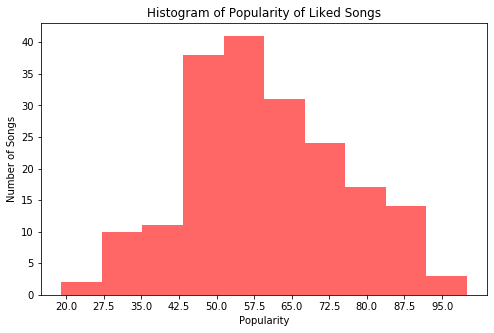

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


count, bin_edges = np.histogram(songs_liked['popularity'], 10, range=(20,95))

songs_liked['popularity'].plot(
    kind='hist', 
    figsize = (8,5),
    xticks = bin_edges,
    alpha = 0.6,
    color = 'red')
plt.title('Histogram of Popularity of Liked Songs') # add a title to the histogram
plt.ylabel('Number of Songs') # add y-label
plt.xlabel('Popularity') # add x-label

In [18]:
songs_liked['timesPlayed'].describe()

count    191.000000
mean      21.950995
std       11.567959
min        4.320000
25%       12.890000
50%       19.470000
75%       28.280000
max       64.220000
Name: timesPlayed, dtype: float64

Text(0.5, 0, 'Times Played')

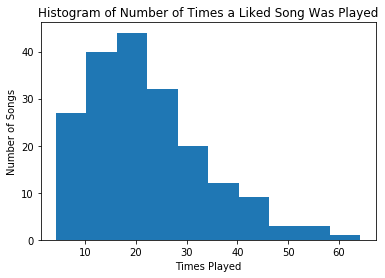

In [19]:
songs_liked['timesPlayed'].plot('hist')

plt.title('Histogram of Number of Times a Liked Song Was Played') # add a title to the histogram
plt.ylabel('Number of Songs') # add y-label
plt.xlabel('Times Played') # add x-label

In [20]:
songs_liked[songs_liked['timesPlayed'] > 58]

,trackName,artistName,msPlayed,uri,popularity,songLengthMs,timesPlayed
39,Derezzed - Remixed by Avicii,Daft Punk,6686806,5X4ojuZG2mZ68EcLyBQ1D3,54.0,104120.0,64.22


Text(0.5, 0, 'Times Played')

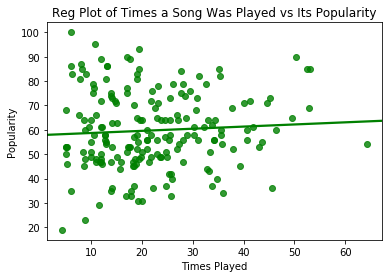

In [21]:
import seaborn as sns

sns.regplot(x='timesPlayed', y='popularity', data=songs_liked, color='green', ci=None)
plt.title('Reg Plot of Times a Song Was Played vs Its Popularity') # add a title to the histogram
plt.ylabel('Popularity') # add y-label
plt.xlabel('Times Played') # add x-label

In [22]:
songs_liked[['timesPlayed', 'popularity']].corr()

,timesPlayed,popularity
timesPlayed,1.000000,0.064361
popularity,0.064361,1.000000


In [16]:
def get_features_of_songs():
    i = 0
    info_list = []
    for idx, row in songs_liked.iterrows():
        result = sp.audio_features(row['uri'])
        result = result[0]

        info_list.append([
            result['danceability'], 
            result['energy'],
            result['key'],
            result['loudness'],
            result['mode'],
            result['speechiness'],
            result['acousticness'],
            result['liveness'],
            result['valence'],
            result['tempo']])

        song_data = pd.DataFrame(info_list)
        song_data.columns = [
            'danceability',
            'energy',
            'key',
            'loudness',
            'mode',
            'speechiness',
            'acousticness',
            'liveness',
            'valence',
            'tempo']

    return(song_data)

In [17]:
song_data = get_features_of_songs()
song_data

,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,0.601,0.609,2,-11.795,1,0.0428,0.010800,0.2490,0.0671,101.973
1,0.526,0.663,0,-4.364,1,0.0362,0.345000,0.0567,0.4090,130.227
2,0.789,0.786,2,-4.788,1,0.2970,0.596000,0.0997,0.3900,119.957
3,0.528,0.511,3,-8.144,1,0.0324,0.126000,0.1010,0.3510,100.100
4,0.631,0.796,1,-5.350,1,0.0401,0.000245,0.3800,0.5960,92.469
...,...,...,...,...,...,...,...,...,...,...
185,0.600,0.412,8,-9.343,1,0.3440,0.615000,0.1340,0.4080,113.049
186,0.582,0.946,0,-3.801,1,0.0340,0.000097,0.2510,0.8060,124.986
187,0.582,0.946,0,-3.801,1,0.0340,0.000097,0.2510,0.8060,124.986
188,0.548,0.653,5,-3.875,1,0.0810,0.456000,0.1030,0.1630,150.068


In [18]:
songs_liked_with_data = pd.concat([songs_liked, song_data], axis=1)
songs_liked_with_data

,trackName,artistName,msPlayed,uri,popularity,songLengthMs,timesPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,America Online,The Midnight,13237685,5eSYigDAtbgTm5iQLTeMJP,52.0,349705.0,37.85,0.601,0.609,2,-11.795,1,0.0428,0.010800,0.2490,0.0671,101.973
1,Until the End of Time,For The Win,12448580,4XcmsnRjjCECEqJvsbH0ot,36.0,272730.0,45.64,0.526,0.663,0,-4.364,1,0.0362,0.345000,0.0567,0.4090,130.227
2,The Search,NF,11221608,2OKo7g3KfmCt3kyLvUAL0g,73.0,248040.0,45.24,0.789,0.786,2,-4.788,1,0.2970,0.596000,0.0997,0.3900,119.957
3,Takeaway (feat. Lennon Stella),The Chainsmokers,11122297,3g0mEQx3NTanacLseoP0Gw,85.0,209880.0,52.99,0.528,0.511,3,-8.144,1,0.0324,0.126000,0.1010,0.3510,100.100
4,BLOW (with Chris Stapleton & Bruno Mars),Ed Sheeran,11059797,6EbduYTr62sSzvl36wWiFM,69.0,209120.0,52.89,0.631,0.796,1,-5.350,1,0.0401,0.000245,0.3800,0.5960,92.469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,Gold,Kiiara,1132086,6ZSO7kPn8IMJFymyticbJO,67.0,225882.0,5.01,0.600,0.412,8,-9.343,1,0.3440,0.615000,0.1340,0.4080,113.049
186,Rebel Girl,Angels & Airwaves,1130035,1EEt3kxO1yZSZd13DqvT8f,53.0,226007.0,5.00,0.582,0.946,0,-3.801,1,0.0340,0.000097,0.2510,0.8060,124.986
187,I'm Not Racist,Joyner Lucas,1127251,1EEt3kxO1yZSZd13DqvT8f,53.0,226007.0,5.00,0.582,0.946,0,-3.801,1,0.0340,0.000097,0.2510,0.8060,124.986
188,Goodbyes (feat. Young Thug),Post Malone,1049118,0t3ZvGKlmYmVsDzBJAXK8C,86.0,174853.0,6.00,0.548,0.653,5,-3.875,1,0.0810,0.456000,0.1030,0.1630,150.068


In [22]:
of_interest = songs_liked_with_data.loc[0:3, 'popularity':'tempo']
of_interest

,popularity,songLengthMs,timesPlayed,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo
0,52.0,349705.0,37.85,0.601,0.609,2,-11.795,1,0.0428,0.0108,0.2490,0.0671,101.973
1,36.0,272730.0,45.64,0.526,0.663,0,-4.364,1,0.0362,0.3450,0.0567,0.4090,130.227
2,73.0,248040.0,45.24,0.789,0.786,2,-4.788,1,0.2970,0.5960,0.0997,0.3900,119.957
3,85.0,209880.0,52.99,0.528,0.511,3,-8.144,1,0.0324,0.1260,0.1010,0.3510,100.100


In [ ]:
import seaborn as sns
sns.pairplot(data=of_interest)

In [29]:
len(songs_liked_with_data[songs_liked_with_data['mode'] == 0])

67

In [30]:
len(songs_liked_with_data[songs_liked_with_data['mode'] == 1])

123

In [50]:
major_vs_minor = songs_liked_with_data[['mode', 'msPlayed']].groupby('mode').sum()
major_vs_minor.at[0, 'msPlayed'] = major_vs_minor.loc[0, 'msPlayed'] / len(songs_liked_with_data[songs_liked_with_data['mode'] == 0])
major_vs_minor.at[1, 'msPlayed'] = major_vs_minor.loc[1, 'msPlayed'] / len(songs_liked_with_data[songs_liked_with_data['mode'] == 1])
major_vs_minor.rename(columns={'msPlayed' : 'averageMsPlayed'}, inplace=True)
major_vs_minor

,averageMsPlayed
mode,
0,4308125
1,4743776


In [51]:
songs_liked_with_data[['timesPlayed', 'energy', 'danceability', 'loudness']].corr()

,timesPlayed,energy,danceability,loudness
timesPlayed,1.000000,-0.083910,-0.017877,-0.108681
energy,-0.083910,1.000000,-0.030681,0.773723
danceability,-0.017877,-0.030681,1.000000,0.044192
loudness,-0.108681,0.773723,0.044192,1.000000
